# Data Exploration & Feature Engineering

This notebook documents the discovery and preparation phase of our project. It serves as a comprehensive Lab Journal for our data strategy, detailing why specific variables were selected, transformed, or excluded based on statistical evidence.

### Objectives

* **Data Exploration (EDA):** Identifying distributions, anomalies, and domain-integrity constraints.
* **Data Cleaning:** Handling missing values and rectifying structural inconsistencies.
* **Feature Engineering:** Encoding categorical variables and deriving new features.
* **Feature Selection:** Justifying the inclusion or exclusion of variables through correlation analysis and visual inspection.

### Project Architecture

To ensure reproducibility and clean production code, we follow a modular structure:

* this notebook: contains the narrative, visual analysis, and "proof of work" for rejected hypotheses.
* `/src` directory: contains the finalized Python scripts used to generate the modeling-ready dataset.

---

### Tips for your GitHub Presentation:

1. **Use Subheadings for "Rejections":** Instead of deleting work your companion didn't like, create a section called `## Feature Analysis: [Variable Name]`. Use a plot to show it wasn't useful, then explicitly state: *"Based on the lack of correlation shown above, this feature was excluded from the final pipeline."*
2. **Highlight the Source Link:** In the "Project Architecture" section, you can actually link to your script: `[Final Dataset Generator](../src/data_prep.py)`. This makes it very easy for a reviewer to jump between your "thinking" (the notebook) and your "doing" (the code).


## Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

#Import data from src
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from src.city_translation import city_map


In [3]:
# Load the dataset
file_path = "../data/tickets_data.csv"
data = pd.read_csv(file_path)

print("\nDataset Info:")
print(data.info())

print("\nUnique Values per Column:")
print(data.nunique())

print("\nFirst 5 Rows of the Dataset:")
print(data.head())

print("\nDataset Describe:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101017 entries, 0 to 101016
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Created               101017 non-null  object 
 1   CancelTime            15326 non-null   object 
 2   DepartureTime         101017 non-null  object 
 3   BillID                101017 non-null  int64  
 4   TicketID              101017 non-null  float64
 5   ReserveStatus         101017 non-null  int64  
 6   UserID                42543 non-null   float64
 7   Male                  101017 non-null  bool   
 8   Price                 101017 non-null  float64
 9   CouponDiscount        101017 non-null  float64
 10  From                  101017 non-null  object 
 11  To                    101017 non-null  object 
 12  Domestic              101017 non-null  int64  
 13  VehicleType           93473 non-null   object 
 14  VehicleClass          62567 non-null 

### Checking Respected Feature Domains 

**Price:**  $x \in \mathbb{R}_+$

In [4]:
zero_price_count = (data['Price'] <= 0).sum()
print(f"Total tickets with Price <= 0: {zero_price_count}")
print("\nCorresponding rows:\n", data[data['Price'] <= 0][['Price', 'CouponDiscount', 'Cancel']])

#dropping those values as they are outliers (all others have price equal or higher than 40000 rials)
data = data[data['Price'] > 0]
print("\nPrice range:\nMax:", data['Price'].max())
print("Min:", data['Price'].min())

Total tickets with Price <= 0: 2

Corresponding rows:
           Price  CouponDiscount  Cancel
6612 -1514000.0             0.0       1
8258        0.0             0.0       1

Price range:
Max: 383764590.0
Min: 40000.0


**CouponDiscount:** $x \in \mathbb{R}_+ \; \wedge \; x <= \text{Price} $

In [5]:
neg_discount_count = (data['CouponDiscount'] < 0).sum()
print(f"Total tickets with CouponDiscount < 0: {neg_discount_count}")
print("\nCorresponding rows:\n", data[data['CouponDiscount'] < 0][['Price', 'CouponDiscount', 'Cancel']])

higher_disc_count = (data['CouponDiscount'] > data['Price']).sum()
print(f"\nTotal tickets with CouponDiscount > Price: {higher_disc_count}")
print("\nCorresponding rows:\n", data[data['CouponDiscount'] > data['Price']][['Price', 'CouponDiscount', 'Cancel']])

# dropping all those values as they are very few
data = data[data['CouponDiscount'] >= 0]
data = data[data['CouponDiscount'] <= data['Price']]

Total tickets with CouponDiscount < 0: 1

Corresponding rows:
          Price  CouponDiscount  Cancel
10041  70000.0         -2000.0       0

Total tickets with CouponDiscount > Price: 9

Corresponding rows:
            Price  CouponDiscount  Cancel
2816     70000.0        220000.0       0
9780   1109000.0       1200000.0       0
11936    70000.0        110000.0       0
16773    70000.0        110000.0       0
26170    70000.0        110000.0       0
35858  1109000.0       1200000.0       0
45898  1078000.0       1200000.0       0
88361    70000.0        110000.0       0
99568    70000.0        110000.0       0


**DepartureTime:** $x > \text{Created}$

In [6]:
# Convert strings to datetime objects first
data['Created'] = pd.to_datetime(data['Created'])
data['DepartureTime'] = pd.to_datetime(data['DepartureTime'])

# Check if there is any strange value\n",
inverse_time_count = (data['DepartureTime'] <= data['Created']).sum()
print(f"Total tickets with DepartureTime pervious to Created: {inverse_time_count}")

Total tickets with DepartureTime pervious to Created: 0


## Data Cleaning

### Data Translation
Translate city names from Persian to English

In [7]:
#get all unique values in From & To columns together
unique_locations = pd.unique(data[['From', 'To']].values.ravel('K'))
print(f"\nTotal Unique Locations in 'From' and 'To' columns: {len(unique_locations)}")
print(unique_locations)


Total Unique Locations in 'From' and 'To' columns: 319
['گرگان' 'مشهد' 'شیراز' 'تبریز' 'تهران' 'بروجرد' 'اصفهان' 'یزد' 'رشت'
 'بوشهر' 'اهواز' 'اراک' 'مشهد (خراسان )' 'قم' 'سیرجان' 'کرج' 'آبادان'
 'زنجان' 'بافق' 'شوشتر' 'اردبیل' 'نجف آباد (اصفهان )' 'خرم آباد (لرستان )'
 'بهبهان' 'خرمشهر' 'رودسر' 'چالوس' 'جهرم' 'کیش' 'کرمان' 'قزوین'
 'گنبدکاووس' 'گلپایگان' 'بندرعباس' 'عسلويه' 'جلفا' 'دیر' 'ارومیه' 'زاهدان'
 'کرمانشاه' 'بابلسر' 'کاشمر' 'گرمسار' 'هشتگرد' 'اقلید' 'لنجان' 'همدان'
 'بیرجند' 'شهرکرد' 'مراغه' 'ساری' 'رامسر' 'بروجن' 'قایم شهر' 'جوین'
 'برخوار' 'سنندج' 'طبس' 'ماسال' 'شاهرود' 'سمنان' 'خواف' 'دامغان' 'دورود'
 'اندیمشک' 'شاهرود (سمنان )' 'تنکابن' 'آستارا' 'گناباد' 'لامرد'
 'کنگان (بوشهر)' 'نور' 'نایروبی' 'استانبول' 'چابهار' 'قشم' 'عسلویه'
 'شهرضا' 'ایرانشهر' 'بابل' 'مهاباد (آذربایجان غربی )' 'ملایر' 'زواره'
 'میلان' 'تاکستان' 'خوی' 'محمدیه' 'خرم دره' 'کاشان' 'گناوه' 'دزفول'
 'تویسرکان' 'خلخال' 'سرخس' 'مرند' 'نیشابور' 'بشرویه' 'ایذه' 'حکاری'
 'کازرون' 'ایلام' 'میانه' 'بانه' 'نوشهر'

In [8]:
# Apply the mapping (found in /src/city_translation.py)
data['From'] = data['From'].map(city_map).fillna(data['From'])
data['To'] = data['To'].map(city_map).fillna(data['To'])

# Check for anything missed
print("Missed Cities in From:", data[~data['From'].isin(city_map.values())]['From'].unique())
print("Missed Cities in To:", data[~data['To'].isin(city_map.values())]['To'].unique())

Missed Cities in From: []
Missed Cities in To: []


### Remove useless columns

We remove the following varaibles:
- `HashPassportNumber_p`, `UserID`, `HashEmail`, `BillID`, `BuyerMobile`, `TicketID`: identification variables, not useful to the prediction of the cancellation probability;
- `CancelTime`: contains data only about the cancelled tickets, if we would add this variable to the model we wold have target leakage
- `VehicleType`: there are too many categories in this variable, it's not possible to retrieve any information about cancellation

In [9]:
data = data.drop(columns=['HashPassportNumber_p', 'UserID', 'HashEmail', 'BillID', 'BuyerMobile', 'TicketID', 'CancelTime','VehicleType'])


We also remove `ReserveStatus`, as we don't have information about the categories meaning. Furthermore, as shown in the plot, there is the risk of target leakage (some categories have high cancellation rates, while others have 0%).

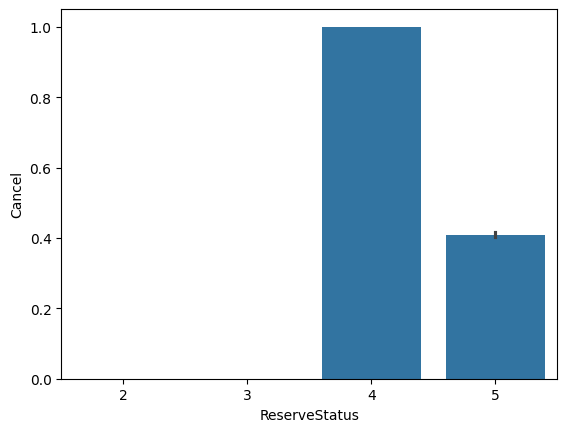

In [10]:
sns.barplot(x='ReserveStatus', y = 'Cancel', data=data)

data = data.drop(columns=['ReserveStatus'])

### Missing Values

In [11]:
missing_info = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data)) * 100
})

print(missing_info.sort_values(by='Missing Percentage', ascending=False))

                Missing Count  Missing Percentage
VehicleClass            38441           38.058512
DepartureTime               0            0.000000
Male                        0            0.000000
Price                       0            0.000000
Created                     0            0.000000
CouponDiscount              0            0.000000
From                        0            0.000000
To                          0            0.000000
Domestic                    0            0.000000
TripReason                  0            0.000000
Vehicle                     0            0.000000
Cancel                      0            0.000000
NationalCode                0            0.000000


The variable `VehicleClass` contains too many missing values to drop them, so we label them as "Unknown".

In [12]:
data['VehicleClass'] = data['VehicleClass'].fillna('Unknown')

### Correlation Check
**Vehicle=InternationalPlane - Domestic=False** 

In [13]:
print("Number of InternationalPlane:", len(data[data['Vehicle']=="InternationalPlane"]))
print("Number of Domestic=False:", len(data[data['Domestic']==0]))
print("Intersection:", len(data[(data['Vehicle']=="InternationalPlane") & (data['Domestic']==0)]))

Number of InternationalPlane: 795
Number of Domestic=False: 795
Intersection: 795


Result: clear 1-1 correlation. We manage it by merging the two categories `Plane` and `InternationalPlane`. 

In [14]:
data['Vehicle'] = data['Vehicle'].replace('InternationalPlane', 'Plane')
# Verify the merge
print("Unique categories after merge:", data['Vehicle'].unique())

Unique categories after merge: ['Plane' 'Bus' 'Train']


**Vehicle=Train - VehicleClass=Unknown**

In [15]:
print("Number of Train:", len(data[data['Vehicle']=="Train"]))
print("Number of VehicleClass=Unknown:", len(data[data['VehicleClass']=="Unknown"]))
print("Intersection:", len(data[(data['Vehicle']=="Train") & (data['VehicleClass']=="Unknown")]))

Number of Train: 38441
Number of VehicleClass=Unknown: 38441
Intersection: 38441


Result: clear 1-1 correlation.

Interpretation: it seems like for trains there is not a differentiation between standard and luxury class.

First possible solution: merge the `Unknown` class under the category `VehicleClass=0`, which means assuming that all trains only have the standard class. We check the cancellation rate in the two classes.

Cancellation Rate for Trains (Unknown Class): 18.46%
Cancellation Rate for Standard Vehicles (Class 0): 12.52%
Cancellation Rate for Luxury Vehicles (Class 1): 13.35%


<Axes: xlabel='VehicleClass', ylabel='Cancel'>

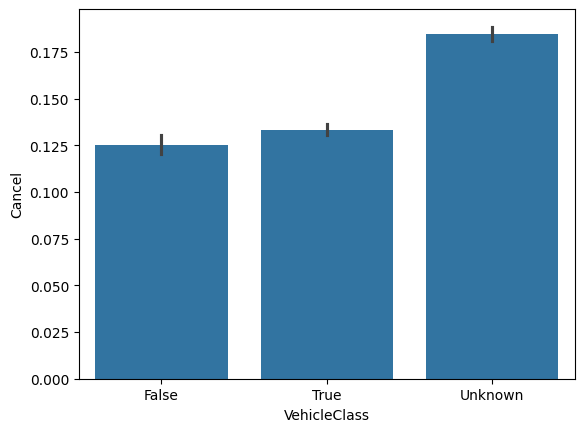

In [16]:
train_cancel_rate = data[data['Vehicle'] == 'Train']['Cancel'].mean()
standard_cancel_rate = data[data['VehicleClass'] == 0]['Cancel'].mean()
luxury_cancel_rate = data[data['VehicleClass'] == 1]['Cancel'].mean()

print(f"Cancellation Rate for Trains (Unknown Class): {train_cancel_rate:.2%}")
print(f"Cancellation Rate for Standard Vehicles (Class 0): {standard_cancel_rate:.2%}")
print(f"Cancellation Rate for Luxury Vehicles (Class 1): {luxury_cancel_rate:.2%}")

sns.barplot(x='VehicleClass', y = 'Cancel', data=data)


The $5.94\%$ difference between the cancellation rate of `VehicleClass=0` and `VehicleClass=Unknown` is pretty high, so merging the two classes would inject noise in the category. 

At the same time, the difference between the two categories `VehicleClass=0` and `VehicleClass=1` is not that relevant, so we decided to directly drop the `VehicleClass` variable, also removing correlation from the dataset.

In [17]:
data=data.drop(columns=['VehicleClass'])

## Feature Engineering

### Categorical Encoding
**Label Encoding**

`TripReason` and `Male` have 2 unique values, but different type (string, bool). For consistency and easier future management, we turn them in integers.

In [18]:
data['TripReason'] = data['TripReason'].map({'Work': 1, 'Int': 0})
data['Male'] = data['Male'].astype(int)

**One Hot Encoding**

We do one hot encoding on the variable `Vehicle`, which now contains three cathegories (Bus, Train and Plane).

In [19]:
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(data[['Vehicle']])

encoded_column = encoder.get_feature_names_out(['Vehicle'])
encoded_data = pd.DataFrame(encoded_array, columns=encoded_column)
encoded_data.index = data.index

# Drop original categorical columns and concatenate with encoded columns
data_encoded = data.drop(columns=['Vehicle'])
data = pd.concat([data_encoded, encoded_data], axis=1)

print("\nData After Encoding:")
data.info()


Data After Encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 101005 entries, 0 to 101016
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Created         101005 non-null  datetime64[ns]
 1   DepartureTime   101005 non-null  datetime64[ns]
 2   Male            101005 non-null  int64         
 3   Price           101005 non-null  float64       
 4   CouponDiscount  101005 non-null  float64       
 5   From            101005 non-null  object        
 6   To              101005 non-null  object        
 7   Domestic        101005 non-null  int64         
 8   TripReason      101005 non-null  int64         
 9   Cancel          101005 non-null  int64         
 10  NationalCode    101005 non-null  int64         
 11  Vehicle_Bus     101005 non-null  int64         
 12  Vehicle_Plane   101005 non-null  int64         
 13  Vehicle_Train   101005 non-null  int64         
dtypes: datetime64[ns](2

### Feature Extraction

- **LeadTime_Days** (float): how many days in advance the ticket was booked. 

*Hypothesis:* people who buy tickets much time in advance, are more likely to cancel due to changing of plans.

In [20]:
data['LeadTime_Days'] = (data['DepartureTime'] - data['Created']).dt.total_seconds() / 86400
data=data.drop(columns=['Created'])

- **PercentageDiscount** (float): percentage of the discount over the price.

*Hypothesis:* people who bought a ticket with a discount paid less for it, so are more prone to cancelling it; moreover, the coupon percentage is much more informative than the absolute value of discount.

However, after creating the variable we noticed that only about $6\%$ of tickets were bought with a discount, so it is a very imbalanced data and may inject noise in the model rather than being useful for prediction.

For good measure, we created the binary variable `Has_Discount` and drawn the conclusion that there is not an actual difference in cancellation rate between having or not a discount. Thus we dropped all the three of them: `CouponDiscount`, `PercentageDiscount` and `Has_Discount`.

Percentage of tickets bought with discount: 5.95%


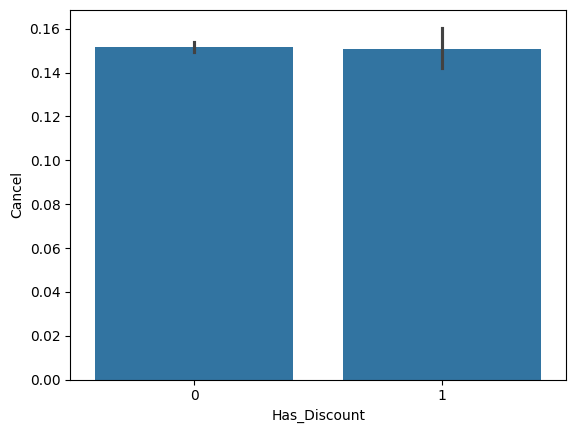

In [21]:
# as just 5% of total tickets have discount and they don't have any effect on the cancelation so we decide to drop it too

data['PercentageDiscount'] = data['CouponDiscount'] / data['Price']

print(f"Percentage of tickets bought with discount: {len(data[data['PercentageDiscount']>0])/len(data):.2%}")

data['Has_Discount'] = (data['CouponDiscount'] > 0).astype(int)
sns.barplot(x='Has_Discount', y='Cancel', data=data)

data = data.drop(columns=['CouponDiscount', 'PercentageDiscount', 'Has_Discount'])


- **LogPrice** (float)

The `Price` range is $[40000.0, 383764590.0]$ but its distribution is strongly skewed: almost all the data is squished into the bottom 0.1, with a few dots stretching way far up. There are outliers: most tickets are cheap (under 5M), but there are a few extremely expensive (100M+). These outliers can confuse linear models like Logistic Regression, so we log-transform `Price`.

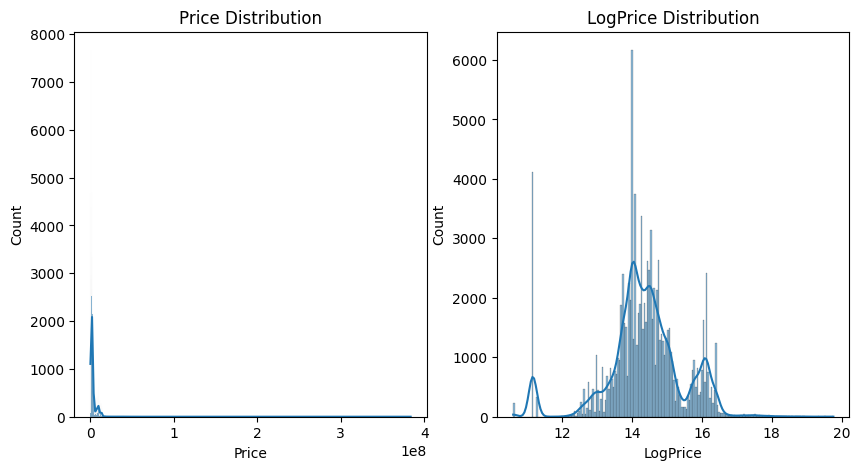

In [22]:
data['LogPrice']=np.log(data['Price'])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x='Price',data=data, kde=True, ax=axes[0])
sns.histplot(x='LogPrice',data=data, kde=True, ax=axes[1])
axes[0].set_title('Price Distribution')
axes[1].set_title('LogPrice Distribution')
plt.show()

data=data.drop(columns=['Price'])

- **MonthDeparture, DayOfWeekDeparture, HourDeparture** (datetime)
  
We analyzed the relationship between flight cancellations and various temporal features: month, day of the week, and day of the month of `DepartureTime`. Our goal was to identify seasonal or hourly patterns that influence cancellation probability.

- `HourDeparture`: A clear correlation was observed, with significantly higher cancellation rates during late-night and early-morning hours.

- `MonthDeparture`:  A sharp spike in cancellations was identified in September. However, contextual research indicates this peak coincided with the nationwide protests in Iran (Sept 2022). This represents an exogenous shock rather than a recurring seasonal trend.

- `DayOfWeekDeparture`: This variable showed a uniform distribution with no statistically significant impact on the target variable.

To prevent the model from skewing to the non-recurring events of September 2022, we will perform **outlier mitigation**: we downsample the cancelled flights for that month to align with the baseline cancellation rate of approximately $15\%$ seen in adjacent months (see `/src`). Moreover, since the primary variance was tied to a one-time event, and there are very few data for the months of January and December, this feature will later be removed to improve model generalization.

We also drop `DayOfWeekDeparture` due to its lack of predictive power, and keep `HourDeparture`, due to the consistent pattern observed.

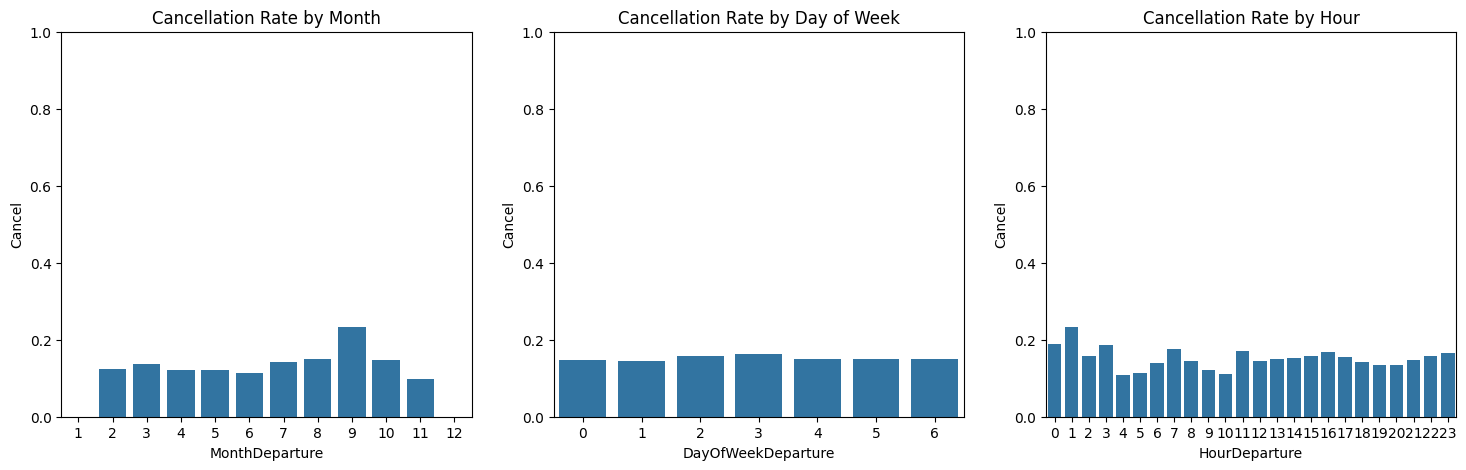

In [23]:
# Extract DepartureTime features
data['MonthDeparture'] = data['DepartureTime'].dt.month
data['DayOfWeekDeparture'] = data['DepartureTime'].dt.dayofweek
data['HourDeparture'] = data['DepartureTime'].dt.hour

# Plot Cancel Rate vs Feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Month
sns.barplot(x='MonthDeparture', y='Cancel', data=data, ax=axes[0], errorbar=None)
axes[0].set_title('Cancellation Rate by Month')
axes[0].set_ylim(0, 1) # Fix y-axis to see true scale

# Plot Day of Week
sns.barplot(x='DayOfWeekDeparture', y='Cancel', data=data, ax=axes[1], errorbar=None)
axes[1].set_title('Cancellation Rate by Day of Week')
axes[1].set_ylim(0, 1)

# Plot Hour
sns.barplot(x='HourDeparture', y='Cancel', data=data, ax=axes[2], errorbar=None)
axes[2].set_title('Cancellation Rate by Hour')
axes[2].set_ylim(0, 1)

plt.show()

data = data.drop(columns=['DepartureTime', 'DayOfWeekDeparture','MonthDeparture'])

### Target Encoding

- **User_Cancel_Rate, User_Total_Tickets**(float, int): rate of cancellation for each user and total number of ticket booked.

*Hypothesis:* a user with a high cancellation rate is likely to cancel again.

- **From_Rate, To_Rate, Route_Rate** (float): cancellation rate per departure city, arrival city and route.
  
The categorical variables `From` and `To` have hundreds of unique values, making traditional One-Hot Encoding computationally expensive and prone to creating a sparse, overfitted feature space. To address this, we compute the historical cancellation probability for each city acting as an origin and a destination, respectively. 

We also created a composite feature `Route` by concatenating the origin and destination (e.g., "Shiraz_Zahedan"). This captures the specific interaction between two points, which might be more predictive than the individual cities alone.

We are testing two distinct hypotheses for the model:

- Providing only `Route_Rate`: this assumes the specific path is the primary driver of cancellations.

- Providing both `From_Rate` and `To_Rate`: this allows the model to learn if a cancellation is due to the single departure or destination's airports, potentially generalizing better to new, rare routes.

**Note:** for both user history and city history we apply the following strategies.

- Smoothed rate:  
$$
    \text{Smoothed Rate} = \frac{(\text{Count}\cdot \text{Mean}) + (\alpha \cdot \mu)}{\text{Count} + \alpha}    
$$    
where $\mu$ is the global average cancellation rate and $\alpha$ is the weight of the smoothing. This is useful to avoid extreme values: without smoothing, if a user has one ticket and it was cancelled, the model sees a 100% cancellation rate, which is rarely a reflection of the user's behavior.  
A lower smoothing weight was chosen for users to allow the model to capture individual passenger behavior more quickly, given the lower transaction frequency per user compared to airport-level data.
- Differentiate train and test data:   
  the actual cancellation rates will be computed only for users, cities and routes in the train dataset. If an element only appears in the test dataset, its cancellation rate will be set to the training dataset mean, in order to avoid data leakage.

In [24]:
def calc_smooth_mean(df, group_col, target_col, weight=20):
    
    global_cancel_mean = df[target_col].mean()
    
    # Calculate count and mean for each category
    stats = df.groupby(group_col)[target_col].agg(['count', 'mean'])
    
    # Apply smoothing formula
    counts = stats['count']
    means = stats['mean']
    smooth = (counts * means + weight * global_cancel_mean) / (counts + weight)
    
    return smooth, global_cancel_mean


In [25]:
# Configuration: {Original_Column: (var_name, Weight)}
feature_config = {
    'From': ('From', 20),
    'To': ('To', 20),
    'Route': ('Route', 20),
    'NationalCode': ('User', 5)  # Maps NationalCode to "User"
}

target_col = 'Cancel'

# Create Route
data['Route'] = data['From'].astype(str) + ' to ' + data['To'].astype(str)

# Target Encoding Loop
for col, (var_name, weight) in feature_config.items():

    # Calculate mapping
    smooth_map, global_mean = calc_smooth_mean(data, group_col=col, target_col=target_col, weight=weight)
    
    # Create Rate variable
    data[f'{var_name}_Rate'] = data[col].map(smooth_map)
    
    # Fill missing values (if any exist)
    data[f'{var_name}_Rate'] = data[f'{var_name}_Rate'].fillna(global_mean)

# Drop original columns
cols_to_drop = list(feature_config.keys())
data = data.drop(columns=cols_to_drop)

# Updated Dataset

In [26]:
print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 101005 entries, 0 to 101016
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Male           101005 non-null  int64  
 1   Domestic       101005 non-null  int64  
 2   TripReason     101005 non-null  int64  
 3   Cancel         101005 non-null  int64  
 4   Vehicle_Bus    101005 non-null  int64  
 5   Vehicle_Plane  101005 non-null  int64  
 6   Vehicle_Train  101005 non-null  int64  
 7   LeadTime_Days  101005 non-null  float64
 8   LogPrice       101005 non-null  float64
 9   HourDeparture  101005 non-null  int32  
 10  From_Rate      101005 non-null  float64
 11  To_Rate        101005 non-null  float64
 12  Route_Rate     101005 non-null  float64
 13  User_Rate      101005 non-null  float64
dtypes: float64(6), int32(1), int64(7)
memory usage: 11.2 MB
None


,Male,Domestic,TripReason,Cancel,Vehicle_Bus,Vehicle_Plane,Vehicle_Train,LeadTime_Days,LogPrice,HourDeparture,From_Rate,To_Rate,Route_Rate,User_Rate
0,1,1,1,0,0,1,0,10.597348,15.702580,23,0.159103,0.162515,0.164001,0.108297
1,1,1,0,0,0,1,0,2.557834,16.066802,4,0.182450,0.162515,0.199761,0.126347
2,0,1,1,0,1,0,0,0.732323,14.508658,11,0.116661,0.213189,0.169355,0.108297
3,0,1,0,0,0,0,1,0.872986,10.596635,8,0.138382,0.032677,0.037002,0.108297
4,1,1,0,0,1,0,0,1.478546,13.937728,23,0.155381,0.116530,0.095546,0.094760


## Feature Selection

In [37]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [38]:
variables = ['Male', 'Domestic', 'TripReason', 'Cancel', 'Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'LeadTime_Days', 'LogPrice', 'HourDeparture', 'From_Rate', 'To_Rate', 'Route_Rate', 'User_Rate']
cont_vars = ['LeadTime_Days', 'LogPrice', 'From_Rate', 'To_Rate', 'Route_Rate', 'User_Rate']
categ_vars = ['Male', 'Domestic', 'TripReason', 'Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'HourDeparture']
target_var = 'Cancel'

print(len(variables))
print(len(cont_vars))
print(len(categ_vars))

14
6
7


### Distributions

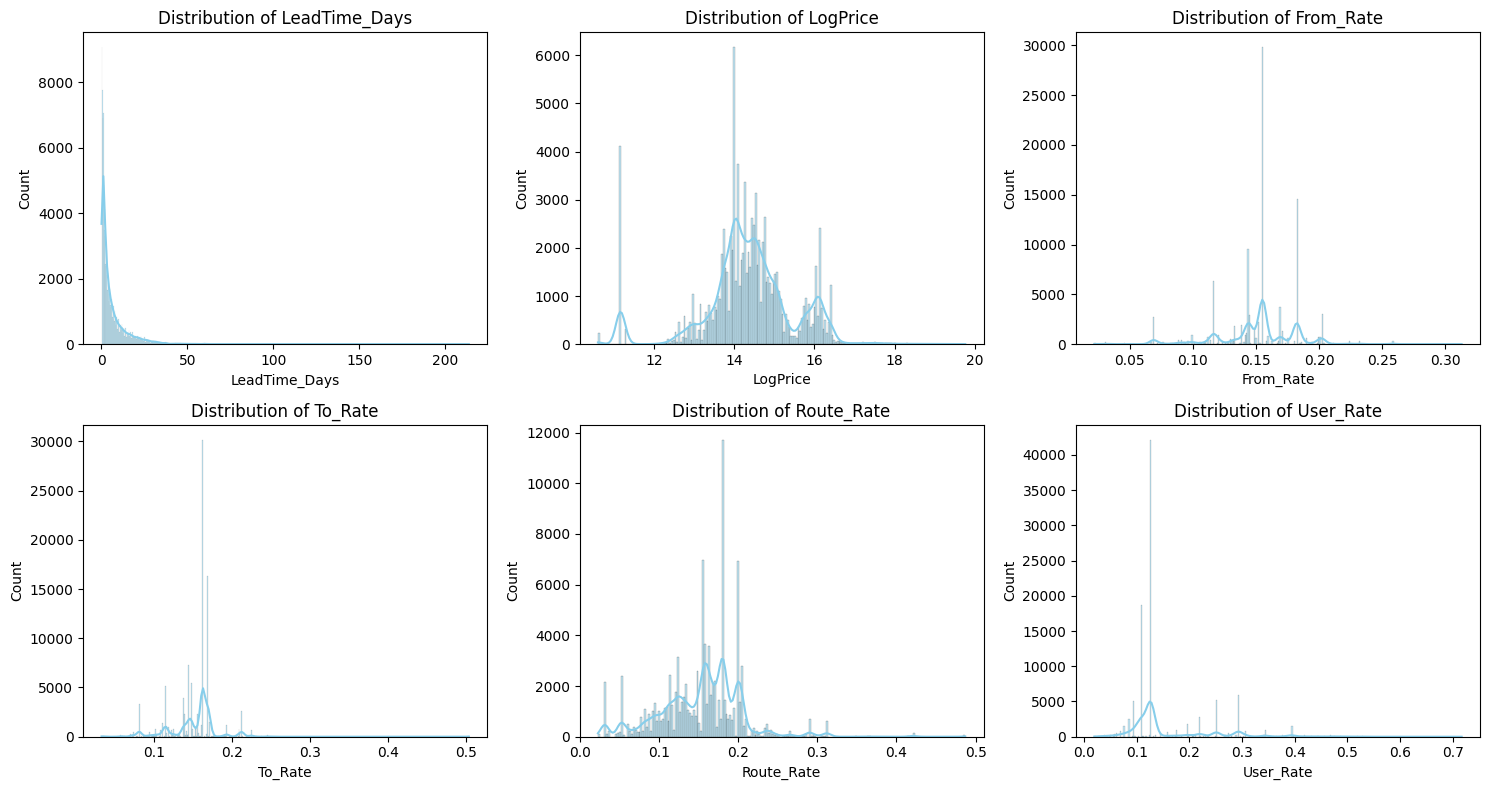

In [39]:
# Plot Continuous Variables
n_cols = 3
n_rows = (len(cont_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cont_vars):
    sns.histplot(data=data, x=col, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')

# Hide empty subplots
for i in range(len(cont_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



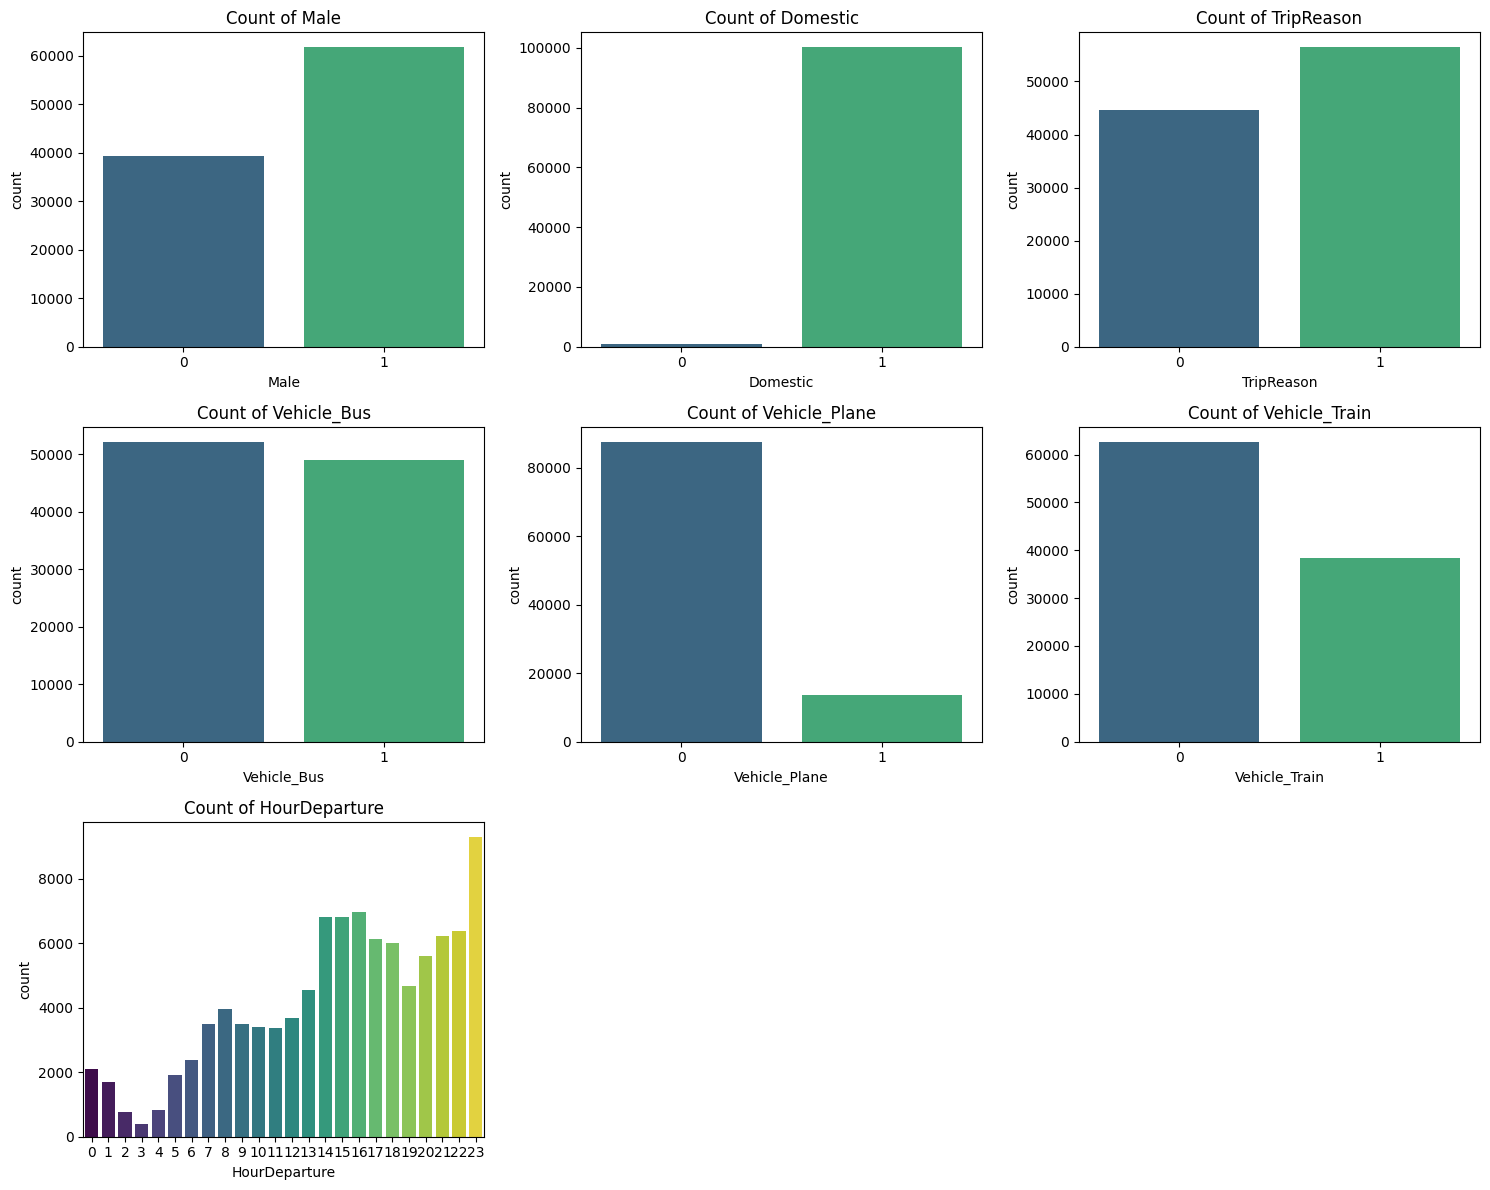

In [40]:
# Plot Categorical Variables
n_cols = 3
n_rows = (len(categ_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categ_vars):
    
    # FIX: Assign 'x' variable to 'hue' and set legend=False
    sns.countplot(data=data, x=col, hue=col, ax=axes[i], palette='viridis', legend=False)
    
    axes[i].set_title(f'Count of {col}')
    axes[i].tick_params(axis='x', rotation=0)

# Hide empty subplots
for i in range(len(categ_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Correlation Matrix

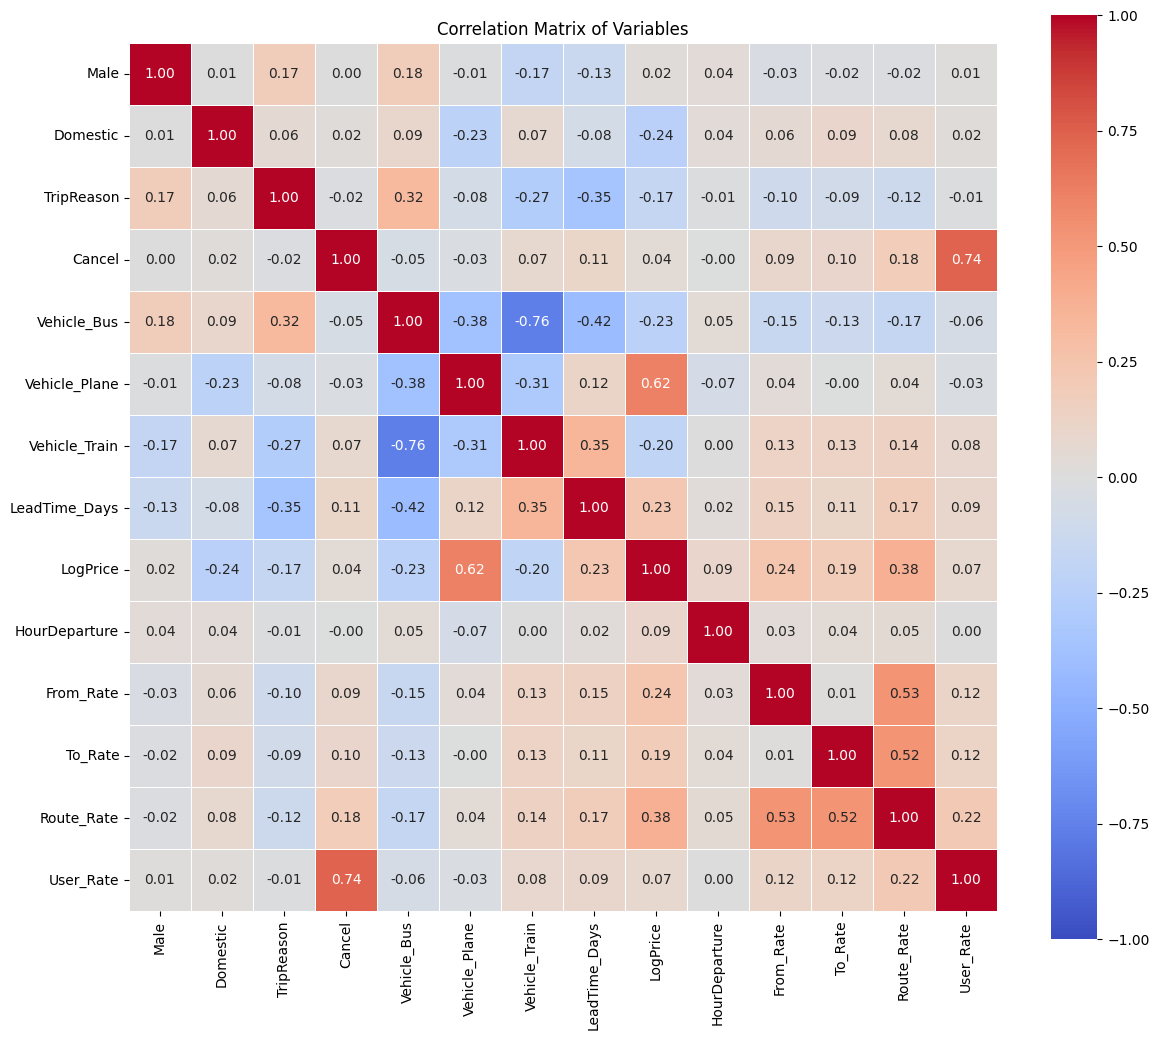

In [41]:
plt.figure(figsize=(14, 12))

# We include the target variable in the correlation matrix
# Ensure all data is numeric for correlation. 
# If 'TripReason' or 'Created' are strings, they must be encoded first.
# Here we calculate correlation only for numeric columns.
numeric_df = data.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

# Mask the upper triangle for better readability
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5)
plt.title('Correlation Matrix of Variables')
plt.show()

### Correlation wrt Cancel

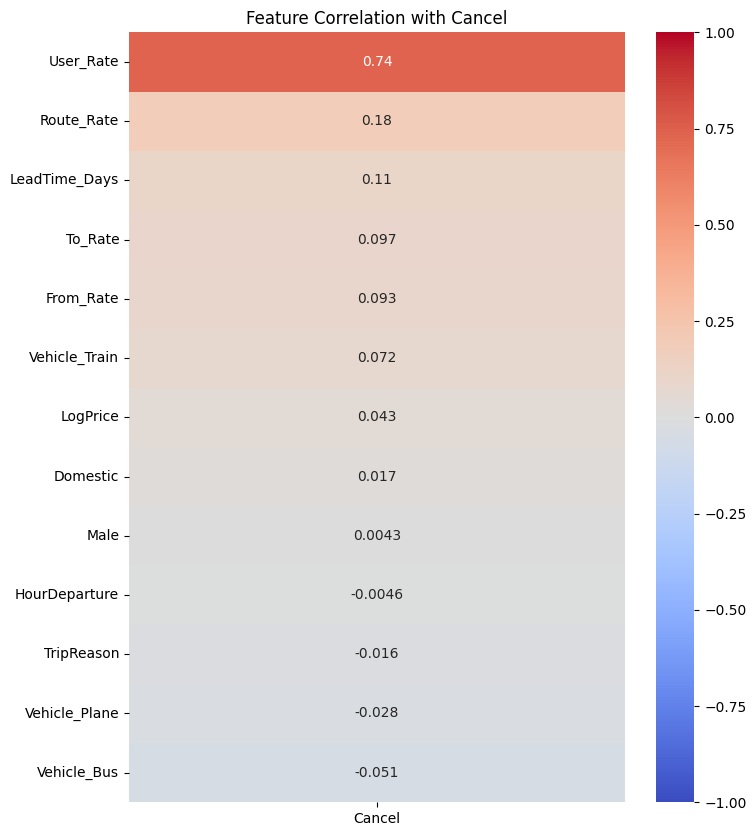

In [42]:
plt.figure(figsize=(8, 10))

# Get correlation series for 'Cancel' and sort it
target_corr = numeric_df.corr()[[target_var]].sort_values(by=target_var, ascending=False)

# Remove the target itself from the list to see other features clearly
target_corr = target_corr.drop(target_var)

sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Feature Correlation with {target_var}')
plt.show()

### Boxplot

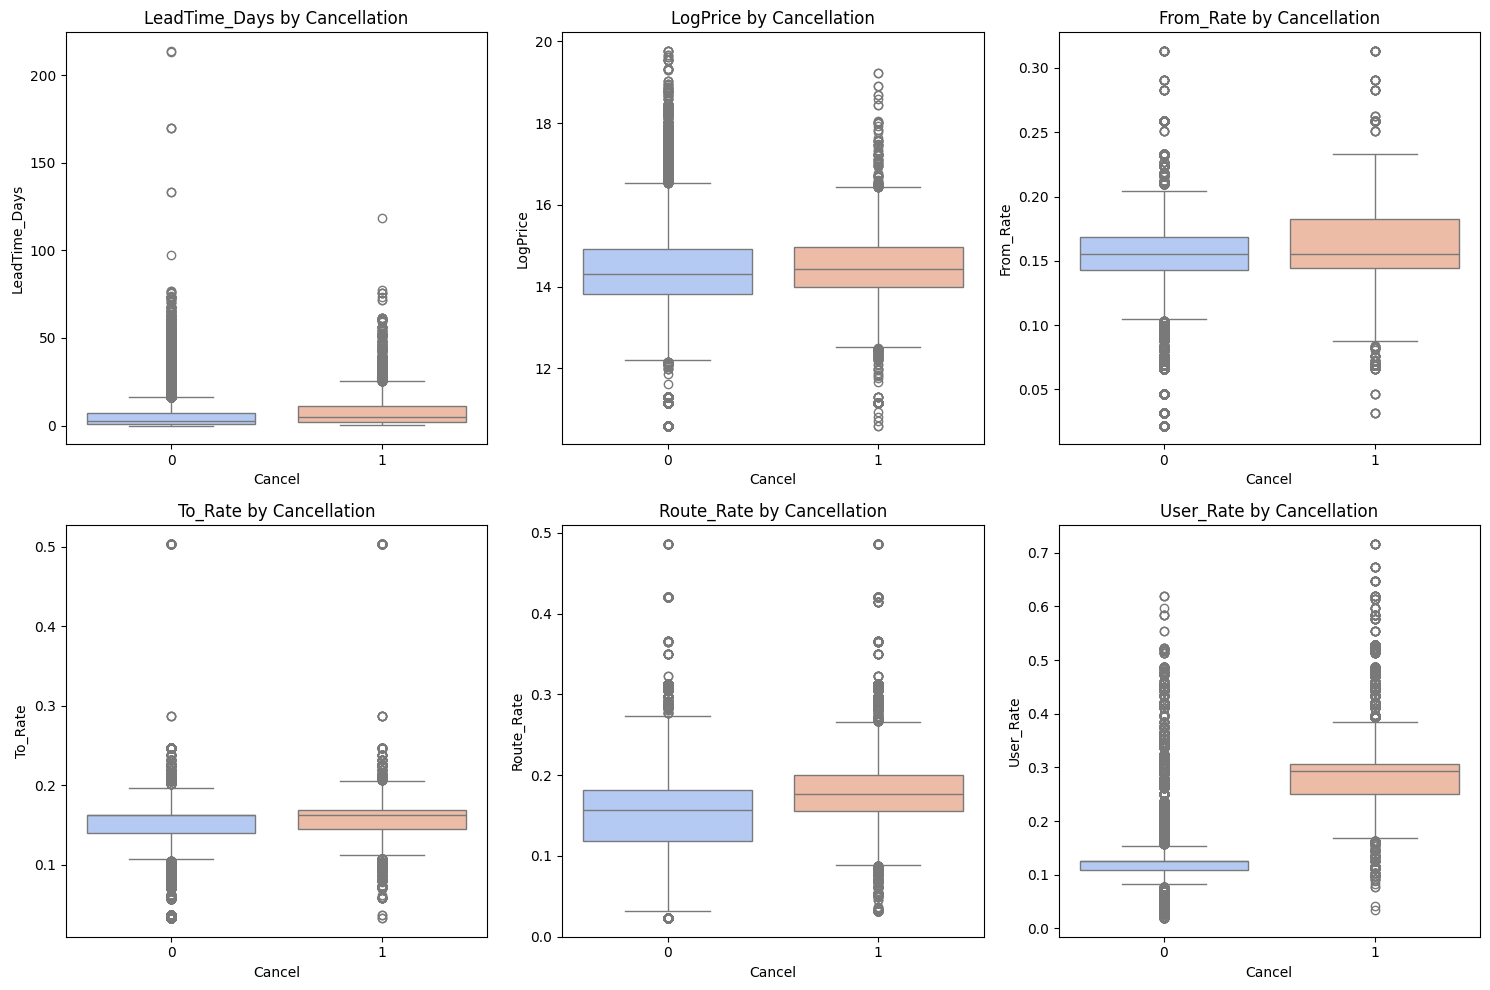

In [44]:
n_cols = 3
n_rows = (len(cont_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cont_vars):
    # Boxplot shows the distribution spread for Cancel=0 vs Cancel=1
    sns.boxplot(data=data, x=target_var, y=col, ax=axes[i], palette='coolwarm', hue=target_var, legend=False)
    axes[i].set_title(f'{col} by Cancellation')

# Hide empty subplots
for i in range(len(cont_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Stacked Bar Charts & Crosstabs (Categorical vs Target)

In [58]:
# We loop through categorical vars to print the Crosstab and plot the Stacked Bar
for col in categ_vars:
    print(f"\n--- Crosstab: {col} vs {target_var} ---")
    crosstab = pd.crosstab(data[col], data[target_var], normalize='index')
    print(crosstab) # Prints the numeric table to console
    


--- Crosstab: Male vs Cancel ---
Cancel         0         1
Male                      
0       0.850332  0.149668
1       0.847144  0.152856

--- Crosstab: Domestic vs Cancel ---
Cancel           0         1
Domestic                    
0         0.918239  0.081761
1         0.847830  0.152170

--- Crosstab: TripReason vs Cancel ---
Cancel             0         1
TripReason                    
0           0.841869  0.158131
1           0.853526  0.146474

--- Crosstab: Vehicle_Bus vs Cancel ---
Cancel              0         1
Vehicle_Bus                    
0            0.830685  0.169315
1            0.867198  0.132802

--- Crosstab: Vehicle_Plane vs Cancel ---
Cancel                0         1
Vehicle_Plane                    
0              0.844407  0.155593
1              0.873934  0.126066

--- Crosstab: Vehicle_Train vs Cancel ---
Cancel                0         1
Vehicle_Train                    
0              0.868662  0.131338
1              0.815379  0.184621

--- Crosstab

### Variance Inflation Factor (VIF)

In [46]:
# We select all numeric features to check for multicollinearity.
# This includes the continuous vars AND the binary indicators (dummies).
features_for_vif = cont_vars + ['Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'Male', 'Domestic']

# Drop missing values to avoid errors in VIF calculation
X_vif = data[features_for_vif].dropna()

# Add a constant (intercept) which is required for the VIF calculation
X_vif = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print("\n--- Variance Inflation Factor (VIF) ---")
print(vif_data.sort_values(by="VIF", ascending=False))

c:\Users\silvi\Desktop\UNI\lab_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\silvi\Desktop\UNI\lab_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



--- Variance Inflation Factor (VIF) ---
          Feature       VIF
8   Vehicle_Plane       inf
9   Vehicle_Train       inf
7     Vehicle_Bus       inf
5      Route_Rate  2.471319
2        LogPrice  2.217415
3       From_Rate  1.638143
4         To_Rate  1.621989
1   LeadTime_Days  1.295269
11       Domestic  1.115454
6       User_Rate  1.056830
10           Male  1.043961
0           const  0.000000


### Pair Plot

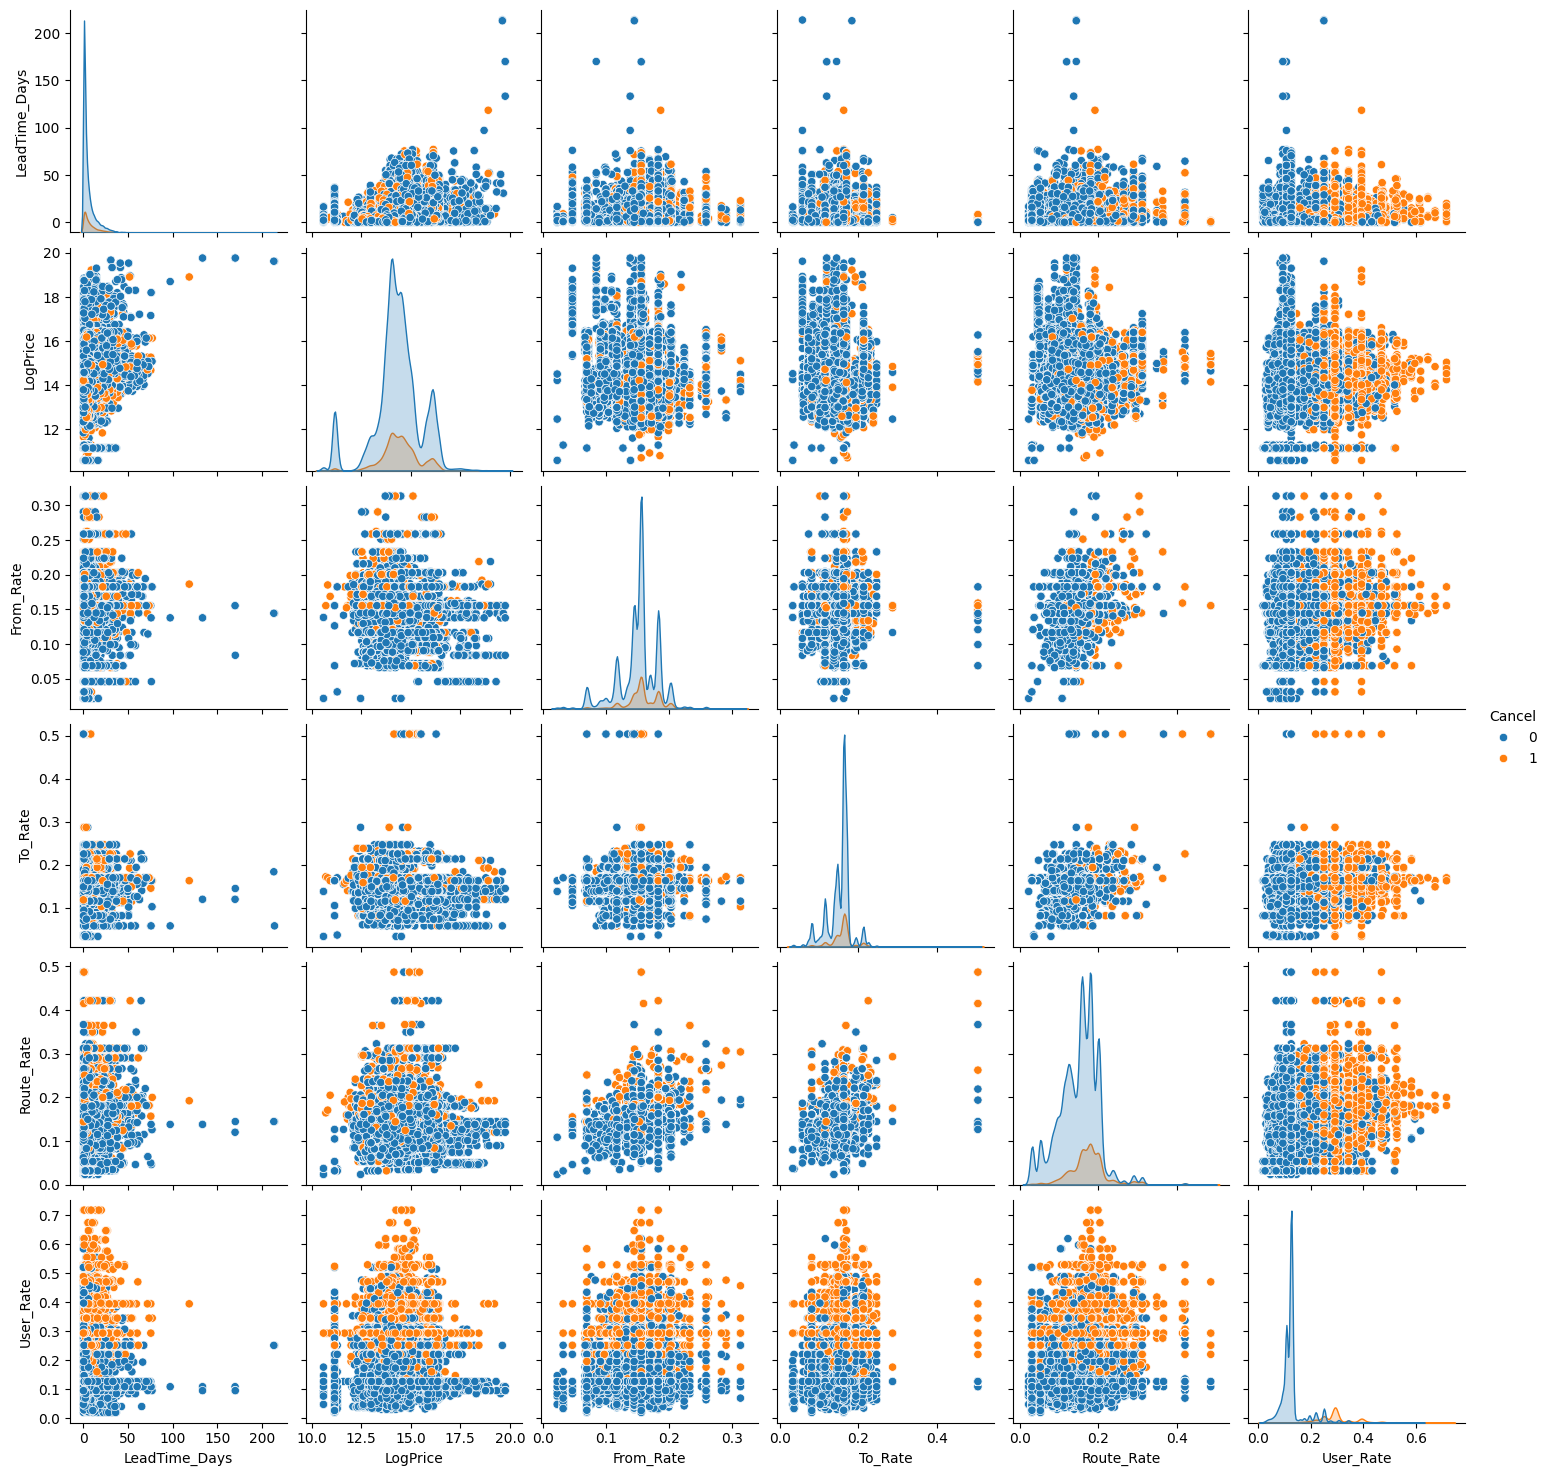

In [48]:
# Plotting pairwise relationships for continuous variables, colored by Cancel
plot_vars = cont_vars + [target_var]
sns.pairplot(data[plot_vars], hue=target_var, diag_kind='kde')
plt.show()

1. Categorical Feature Analysis (Crosstabs)
This section evaluates whether knowing a category helps predict if a user will cancel.

- Weak / Useless Features (Drop Candidates):

Male (Gender): The difference is negligible (14.9% vs. 15.2% cancel rate). Knowing the gender provides almost zero predictive power.

TripReason: Similar issue (15.8% vs. 14.6%). The reason for the trip does not strongly influence the decision to cancel.

Vehicle_Plane & Vehicle_Bus: The differences in cancellation rates are small (only ~2-3% variation between classes). While not strictly zero, their individual impact is weak.

- Strong / Good Features (Keep):

Vehicle_Train: This shows a clear split. Train trips (1) have an 18.5% cancel rate, while non-train trips (0) have only 13.1%. This ~5.4% jump is significant.

Domestic: Very strong predictor. International/Non-domestic (0) trips have very low cancellations (8.2%), whereas Domestic (1) trips cancel nearly twice as often (15.2%).

HourDeparture: High variability. Early hours like 4 AM–5 AM have very low cancel rates (~10-11%), while 1 AM or 11 PM are much riskier (~17-23%). This cyclic pattern is valuable for the model.

2. Continuous Feature Analysis (Boxplots & Pairplot)
User_Rate (Strongest Feature):

Observation: In the boxplot, the orange box (Cancel=1) is distinctly higher than the blue box (Cancel=0).

Pairplot confirmation: In the bottom-right corner of the pairplot (density curve), the orange peak is shifted significantly to the right.

Meaning: Users with higher historical cancellation rates are much more likely to cancel again. This is likely your most predictive feature.

LeadTime_Days (Good Feature):

Observation: The boxplot shows that cancelled tickets generally have a larger spread and slightly higher median lead time. The "outliers" (dots) go much higher for cancellations. People booking very far in advance are more uncertain and prone to cancelling.

LogPrice (Weak/Neutral):

Observation: The distributions for Cancel=0 and Cancel=1 are nearly identical in the boxplot. The price does not seem to act as a strong linear separator on its own.

3. Multicollinearity Analysis (VIF)
The "Infinity" Problem:

Vehicle_Plane, Vehicle_Train, and Vehicle_Bus have VIF = inf.

Reason: As suspected, Bus + Plane + Train = 1. They are perfectly correlated.

Action: Since you are using a regularized model (Lasso/Ridge Logistic Regression), you can technically leave them in. However, if you switch to a non-regularized model, you must drop one (e.g., drop Vehicle_Bus and keep the others as indicators).

Safe Variables:

All continuous variables (Route_Rate, LogPrice, From_Rate, etc.) have VIF < 3. There is no dangerous multicollinearity among the numeric data.


1. Correlation with Target ('Cancel')
Goal: Identify which individual variables have a strong linear relationship with cancellation.

User_Rate (0.74): This is a massive positive correlation. As User_Rate (the user's historical cancellation rate) increases, the probability of the current ticket being cancelled increases drastically. This confirms it is by far your most important feature.

Route_Rate (0.18): Moderate positive correlation. Some routes are inherently more prone to cancellations than others. This is a solid predictive feature.

LeadTime_Days (0.11): Weak positive correlation. As observed in the boxplots, booking further in advance slightly increases cancellation risk, but the linear link is not very strong.

Vehicle_Bus (-0.05) & Vehicle_Plane (-0.03): Very weak negative correlations. On their own, they don't strongly predict cancellations linearly. This aligns with the crosstab finding that their cancellation rates are close to the average.

Male (0.004) & HourDeparture (-0.005): Virtually zero correlation. Linearly, these features are noise. However, recall that HourDeparture had a non-linear "cyclic" pattern (late nights were risky, mornings safe), which a simple correlation coefficient ($r$) cannot capture.

2. Correlation Between Features (Multicollinearity)
Goal: Check if features are redundant (repeating the same information).

Vehicle_Bus vs Vehicle_Train (-0.76): Strong negative correlation. This is expected (if it's a bus, it's not a train). As discussed, this is acceptable for regularized models.

LogPrice vs Vehicle_Plane (0.62): Moderate correlation. Plane tickets are consistently more expensive. This means LogPrice might partially be acting as a proxy for "Vehicle Type." If you keep both, the model has to decide which one is actually driving the cancellation risk.

From_Rate, To_Rate, Route_Rate:
Route_Rate and From_Rate have a correlation of 0.53.
Route_Rate and To_Rate have a correlation of 0.52.
This makes sense: The cancellation rate of a specific route (e.g., Paris->Lyon) is naturally related to the cancellation rate of the origin (Paris) and destination (Lyon).
Decision: You might not need all three. Route_Rate is likely the most specific and powerful. If you need to simplify, you could drop From_Rate and To_Rate without losing much information.

Feature,Correlation Verdict,Action
User_Rate,High (0.74),Mandatory. The single best predictor.
Route_Rate,Moderate (0.18),Keep. Good predictor.
From_Rate / To_Rate,Moderate (~0.10),Consider Dropping. They are correlated with Route_Rate (0.53) but have weaker correlation with the target. Route_Rate likely covers this info.
HourDeparture,Zero (-0.005),"Keep (despite low correlation) because the relationship is non-linear (cyclic), which r misses."
LogPrice,Weak (0.04),Weak. It is correlated with Vehicle_Plane (0.62) but has low correlation with Cancel. It might not add unique value.

In [ ]:
# data=data.drop(columns=['Male'])

In [ ]:
# output_dir = "../data/"

# os.makedirs(output_dir, exist_ok=True)

# # Save the dataset
# data.to_csv(os.path.join(output_dir, "updated_data.csv"), index=False)